<a href="https://colab.research.google.com/github/joyceezhao/NLP/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Patronizing and Condescending Language Detection

In [ ]:
!pip -q install transformers datasets    

In [ ]:
!nvidia-smi

Fri Mar  4 00:42:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Prepare Dataset

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
from tqdm.notebook import tqdm
from transformers import RobertaTokenizer, BertTokenizer
from torch.utils.data import TensorDataset
from transformers import RobertaForSequenceClassification, BertForSequenceClassification
import seaborn as sns

In [ ]:
#Skip beginning rows of the file
df_pcl = pd.read_csv('dontpatronizeme_pcl.csv', sep='\t', skiprows=4, header = None)
df_pcl.columns = ['index','paragraph_id',	'keyword', 'country_code',	'paragraph', 'label']
df_pcl.drop('index', axis = 1, inplace=True)
df_pcl

,paragraph_id,keyword,country_code,paragraph,label
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0
...,...,...,...,...,...
10464,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1
10465,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0
10466,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3
10467,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4


,migrant,in-need,vulnerable,homeless,women,refugee,immigrant,disabled,hopeless,poor-families
0,0.956801,0.84658,0.926852,0.84494,0.933645,0.919476,0.961357,0.919261,0.884577,0.850385
1,0.043199,0.15342,0.073148,0.15506,0.066355,0.080524,0.038643,0.080739,0.115423,0.149615


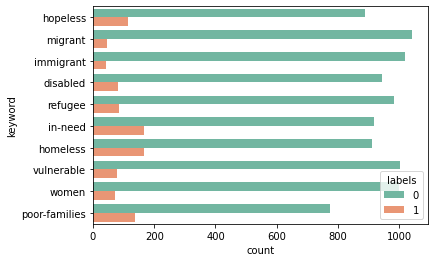

In [ ]:
p = df_pcl
p = p.dropna().reset_index()
p['labels'] = 0
p.loc[df_pcl.label.isin([2,3,4]), 'labels'] = 1 
sns.countplot(y="keyword", hue="labels", data=p, palette="Set2")
keylabel = {}
keyc = p['keyword'].value_counts()
for key, count in keyc.items():
  # print(key, count)
  labelc = p[p['keyword']==key]['labels'].value_counts()
  keylabel[key]=[labelc[0]/count, labelc[1]/count]
  # print('0', labelc[0]/count)
  # print('1', labelc[1]/count)
keylabel_frame = pd.DataFrame(keylabel)
keylabel_frame

In [ ]:
p['lens'] = 0
p['lens'] = p.apply(lambda row:len(row['paragraph'].split(' ')), axis=1)
paralen = p['lens'].value_counts()
con = [0 for _ in range(5)]
conlabel = [0 for _ in range(5)]
paraname = ['<=20', '21-40', '41-60', '61-100', '>100']
para = {}
for key, count in paralen.items():
  # print(key, count)
  if key<=20:
    con[0] += count
    conlabel[0] += p[p['lens']==key]['labels'].sum()
  elif 20<key<=40:
    con[1] += count
    # print(p[p['lens']==key])
    conlabel[1] += p[p['lens']==key]['labels'].sum()
  elif 40<key<=60:
    con[2] += count
    conlabel[2] += p[p['lens']==key]['labels'].sum()
  elif 60<key<=100:
    con[3] += count
    conlabel[3] += p[p['lens']==key]['labels'].sum()
  else:
    con[4] += count
    conlabel[4] += p[p['lens']==key]['labels'].sum()
for i in range(len(con)):
  para[paraname[i]] = [1-conlabel[i]/con[i], conlabel[i]/con[i]]
para = pd.DataFrame(para)
para

,<=20,21-40,41-60,61-100,>100
0,0.913921,0.919318,0.903421,0.889442,0.855311
1,0.086079,0.080682,0.096579,0.110558,0.144689


#Test set

In [ ]:
df_pcl_test = pd.read_csv('task4_test.csv', sep='\t', header = None)
df_pcl_test.columns = ['index','paragraph_id',	'keyword', 'country_code',	'paragraph']
df_pcl_test

,index,paragraph_id,keyword,country_code,paragraph
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C..."
...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina..."
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...


#Drop null in paragraph column

In [ ]:
df_pcl.isnull().sum()

paragraph_id    0
keyword         0
country_code    0
paragraph       1
label           0
dtype: int64

In [ ]:
df_pcl = df_pcl.dropna().reset_index()
df_pcl.isnull().sum()

index           0
paragraph_id    0
keyword         0
country_code    0
paragraph       0
label           0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


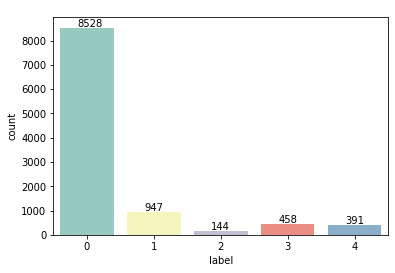

In [ ]:
import matplotlib.pyplot as plt
# s1 = sns.countplot(df_pcl['label'], palette="Set3");
fig,ax = plt.subplots()
s1 = sns.countplot(df_pcl['label'], palette="Set3");
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.26, p.get_height()+50), color='black', size=10)
plt.show()

#[0,1,2,3,4] --> [0,1]
From [the paper](https://arxiv.org/pdf/2011.08320.pdf):


> for Task 1 we view paragraphs labelled with 0 or 1 as negative examples, and the remaining paragraphs, labelled with 2, 3 or 4, as positive examples



In [ ]:
df_pcl['labels'] = 0
df_pcl.loc[df_pcl.label.isin([2,3,4]), 'labels'] = 1 
df_pcl.drop('index', axis=1, inplace=True)
df_pcl

,paragraph_id,keyword,country_code,paragraph,label,labels
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0
...,...,...,...,...,...,...
10463,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0
10464,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10465,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1
10466,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


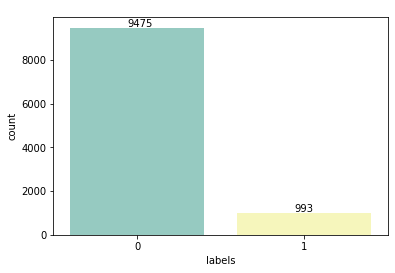

In [ ]:
# s2 = sns.countplot(df_pcl['labels'], palette="Set3");
fig,ax = plt.subplots()
s2 = sns.countplot(df_pcl['labels'], palette="Set3");
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.34, p.get_height()+50), color='black', size=10)
plt.show()

# Training using Huggingface API

##Combined Features for Training set

In [ ]:
def combine_features(row) :
  return '</s>'.join(row.drop(['paragraph_id','labels','label'],axis=0).apply(str).values)
df_pcl['combined_features'] = df_pcl.apply(combine_features, axis = 1)
df_pcl.head(10)

,paragraph_id,keyword,country_code,paragraph,label,labels,combined_features
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,hopeless</s>ph</s>We 're living in times of ab...
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,"migrant</s>gh</s>In Libya today , there are co..."
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0,immigrant</s>ie</s>White House press secretary...
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,disabled</s>nz</s>Council customers only signs...
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0,"refugee</s>ca</s>"" Just like we received migra..."
5,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0,0,in-need</s>in</s>To bring down high blood suga...
6,@@7562079,refugee,za,The European Union is making an historic mista...,0,0,refugee</s>za</s>The European Union is making ...
7,@@23663488,hopeless,nz,""" They 're either hopeless for being beaten by...",0,0,"hopeless</s>nz</s>"" They 're either hopeless f..."
8,@@3449225,homeless,ph,"NUEVA ERA , Ilocos Norte - No family shall be ...",1,0,"homeless</s>ph</s>NUEVA ERA , Ilocos Norte - N..."
9,@@2485090,in-need,nz,His spokesman said the Kremlin needed more inf...,0,0,in-need</s>nz</s>His spokesman said the Kremli...


In [ ]:
df_pcl_train = df_pcl
df_pcl_train

,paragraph_id,keyword,country_code,paragraph,label,labels,combined_features
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,hopeless</s>ph</s>We 're living in times of ab...
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,"migrant</s>gh</s>In Libya today , there are co..."
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0,immigrant</s>ie</s>White House press secretary...
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,disabled</s>nz</s>Council customers only signs...
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0,"refugee</s>ca</s>"" Just like we received migra..."
...,...,...,...,...,...,...,...
10463,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0,women</s>lk</s>Sri Lankan norms and culture in...
10464,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0,vulnerable</s>ph</s>He added that the AFP will...
10465,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1,"in-need</s>ng</s>"" She has one huge platform ,..."
10466,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4,1,"hopeless</s>in</s>"" Anja Ringgren Loven I ca n..."


##Combined features for test set

In [ ]:
def combine_features(row) :
  return '</s>'.join(row.drop(['index','paragraph_id'],axis=0).apply(str).values)
df_pcl_test['combined_features'] = df_pcl_test.apply(combine_features, axis = 1)
df_pcl_test

,index,paragraph_id,keyword,country_code,paragraph,combined_features
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to...","vulnerable</s>us</s>In the meantime , conserva..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...,women</s>pk</s>In most poor households with no...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...,migrant</s>ca</s>The real question is not whet...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population...","migrant</s>gb</s>In total , the country 's imm..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C...","vulnerable</s>ca</s>Members of the church , wh..."
...,...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...,migrant</s>jm</s>In a letter dated Thursday to...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...,poor-families</s>au</s>They discovered that po...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina...","migrant</s>ca</s>She married at 19 , to Milan ..."
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...,immigrant</s>us</s>The United Kingdom is n't g...


#Validation set

In [ ]:
df_pcl_valid = df_pcl.sample(frac = 0.1, random_state = 2)
df_pcl_train = df_pcl.drop(df_pcl_valid.index, axis=0)

#Oversampling
Replicate rows with lable 1 in train dataframe

In [ ]:
replicated_pcls = pd.concat([df_pcl_train[df_pcl_train['labels'] == 1]]*8, ignore_index=True)

In [ ]:
df_pcl_train = pd.concat([df_pcl_train, replicated_pcls])

In [ ]:
df_pcl_train

,paragraph_id,keyword,country_code,paragraph,label,labels,combined_features
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,hopeless</s>ph</s>We 're living in times of ab...
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,"migrant</s>gh</s>In Libya today , there are co..."
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0,immigrant</s>ie</s>White House press secretary...
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0,"refugee</s>ca</s>"" Just like we received migra..."
5,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0,0,in-need</s>in</s>To bring down high blood suga...
...,...,...,...,...,...,...,...
7091,@@4665292,women,jm,""" I do n't believe in abortion , I think it is...",3,1,"women</s>jm</s>"" I do n't believe in abortion ..."
7092,@@3923193,refugee,gb,More than 150 volunteers spent the night in ' ...,3,1,refugee</s>gb</s>More than 150 volunteers spen...
7093,@@22338535,vulnerable,ie,""" We are challenged , I suggest , to turn this...",4,1,"vulnerable</s>ie</s>"" We are challenged , I su..."
7094,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1,"in-need</s>ng</s>"" She has one huge platform ,..."


### Create Dataset from Dataset


In [ ]:
from datasets import Dataset
raw_datasets_valid = Dataset.from_pandas(df_pcl_valid[['combined_features','labels']])
raw_datasets_train = Dataset.from_pandas(df_pcl_train[['combined_features','labels']])
raw_datasets_test  = Dataset.from_pandas(df_pcl_test[['combined_features']])

raw_datasets_train, raw_datasets_valid, raw_datasets_test

(Dataset({
     features: ['combined_features', 'labels', '__index_level_0__'],
     num_rows: 16517
 }), Dataset({
     features: ['combined_features', 'labels', '__index_level_0__'],
     num_rows: 1047
 }), Dataset({
     features: ['combined_features'],
     num_rows: 3832
 }))

In [ ]:
from transformers import AutoTokenizer
model_name = 'roberta-large'
# model_name = 'bert-base-uncased'
# model_name = 'roberta-large-openai-detector'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#Tokenization

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["combined_features"], padding="max_length", truncation=True)

tokenized_datasets_train = raw_datasets_train.map(tokenize_function, batched=True)
tokenized_datasets_valid = raw_datasets_valid.map(tokenize_function, batched=True)
tokenized_datasets_test = raw_datasets_test.map(tokenize_function, batched=True)

tokenized_datasets_train = tokenized_datasets_train.remove_columns(["__index_level_0__", 'combined_features'])
tokenized_datasets_valid = tokenized_datasets_valid.remove_columns(["__index_level_0__", 'combined_features'])
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['combined_features'])

tokenized_datasets_test

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 3832
})

In [ ]:
small_dataset_size = 1000
small_train_dataset = tokenized_datasets_train.shuffle(seed=2).select(range(small_dataset_size))
small_eval_dataset = tokenized_datasets_valid.shuffle(seed=2).select(range(small_dataset_size//10))
# small_eval_dataset = tokenized_datasets_valid.shuffle(seed=2)
small_test_dataset = tokenized_datasets_test.shuffle(seed=2).select(range(small_dataset_size//10))

full_train_dataset = tokenized_datasets_train
full_eval_dataset = tokenized_datasets_valid
full_test_dataset = tokenized_datasets_test


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

In [ ]:
from datasets import load_metric, list_metrics
from sklearn.metrics import f1_score
from transformers import TrainingArguments
from transformers import Trainer
import numpy as np

f1_history = []

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    f1 = f1_score(labels, predictions, average='macro')
    f1_history.append(f1)
    return {'f1': f1}

# lrp = [1e-6, 1e-5, 1e-4, 1e-3]

training_args = TrainingArguments(output_dir='test',
                                  num_train_epochs=1,
                                  save_total_limit=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy= "epoch",
                                  per_device_train_batch_size=4,
                                  warmup_steps=200,
                                  lr_scheduler_type='cosine') 

trainer = Trainer(
    model=model, args=training_args,
    train_dataset = full_train_dataset,
    eval_dataset = full_eval_dataset,
    # train_dataset=small_train_dataset,
    # eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16517
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4130


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
!nvidia-smi

In [ ]:
# trainer.train()

In [ ]:
f1_history

[0.9299171768737841]

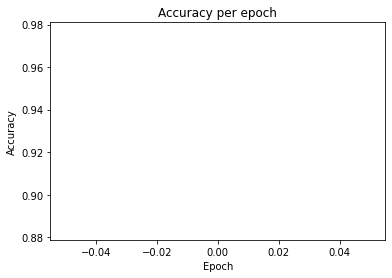

In [ ]:
f = plt.figure()
plt.plot(f1_history)
plt.title('Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
f.savefig("accuracy.png", bbox_inches='tight')

In [ ]:
trainer.evaluate()

In [ ]:
predictions = trainer.predict(full_eval_dataset)

In [ ]:
# p = df_pcl_valid
# p['lens'] = p.apply(lambda row:len(row['paragraph'].split(' ')), axis=1)
# valid_split = [[]for _ in range(5)]
# for i,j,k in zip(p['combined_features'], p['labels'], p['lens']):
#   if k<=20:
#     valid_split[0].append([i,j])
#   elif 20<k<=40:
#     valid_split[1].append([i,j])
#   elif 40<k<=60:
#     valid_split[2].append([i,j])
#   elif 60<k<=100:
#     valid_split[3].append([i,j])
#   else:
#     valid_split[4].append([i,j])
# # print(valid_split)
# tokenized_datasets_valid = []
# for i in range(5):
#   data_f = pd.DataFrame(valid_split[i], columns = ['combined_features','labels'])
#   # print(data_f)
#   raw_datasets_valid=Dataset.from_pandas(data_f)
#   tokenized_datasets=raw_datasets_valid.map(tokenize_function, batched=True)
#   tokenized_datasets_valid.append(tokenized_datasets.remove_columns(['combined_features']))

# tokenized_datasets_valid[0]
# tokenized_datasets_valid = raw_datasets_test.map(tokenize_function, batched=True)
# tokenized_datasets_train = tokenized_datasets_train.remove_columns(["__index_level_0__", 'combined_features'])
# predictions = trainer.predict(full_eval_dataset)



  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 100
  Batch size = 8


In [ ]:
pred = np.argmax(predictions.predictions, axis=1)

In [ ]:
# from sklearn.metrics import confusion_matrix 

# for i in range(5):
#   predictions = trainer.predict(tokenized_datasets_valid[i])
#   pred = np.argmax(predictions.predictions, axis=1)
#   f1 = f1_score(tokenized_datasets_valid[i]['labels'], pred, average='macro')
#   print(f1)




***** Running Prediction *****
  Num examples = 100
  Batch size = 8


***** Running Prediction *****
  Num examples = 400
  Batch size = 8


0.6915260388314282


***** Running Prediction *****
  Num examples = 299
  Batch size = 8


0.7790220231429638


***** Running Prediction *****
  Num examples = 193
  Batch size = 8


0.733511586452763


***** Running Prediction *****
  Num examples = 55
  Batch size = 8


0.7381275440976933
0.6762974852862493


In [ ]:
y_pred = trainer.predict(full_test_dataset)

***** Running Prediction *****
  Num examples = 3832
  Batch size = 8


In [ ]:
y_pred.predictions.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y = y_pred.predictions.argmax(axis=1)
y, len(y)

(array([0, 0, 0, ..., 0, 0, 0]), 3832)

In [ ]:
np.savetxt('task1.txt', y, fmt="%s")

In [ ]:
!zip submission.zip task1.txt

  adding: task1.txt (deflated 94%)


In [ ]:
torch.cuda.empty_cache()